In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from sklearn.metrics import f1_score, accuracy_score

import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

import seaborn as sns
from tqdm import tqdm

import torch.optim as optim
import torch
import torch.nn as nn

from scipy.io import loadmat

import wandb


In [2]:
batch_size = 64
classes = list(range(10))

In [3]:


# Download the training dataset
trainset = MNIST(root='data/', train=True,
                      transform=ToTensor(), download=True)

# Download the test dataset
testset = MNIST(root='data/', train=False,
                     transform=ToTensor(), download=True)

In [4]:
len(trainset), len(testset)

(60000, 10000)

In [5]:
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset,
                                           [train_size, val_size])


In [6]:
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    valset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False)


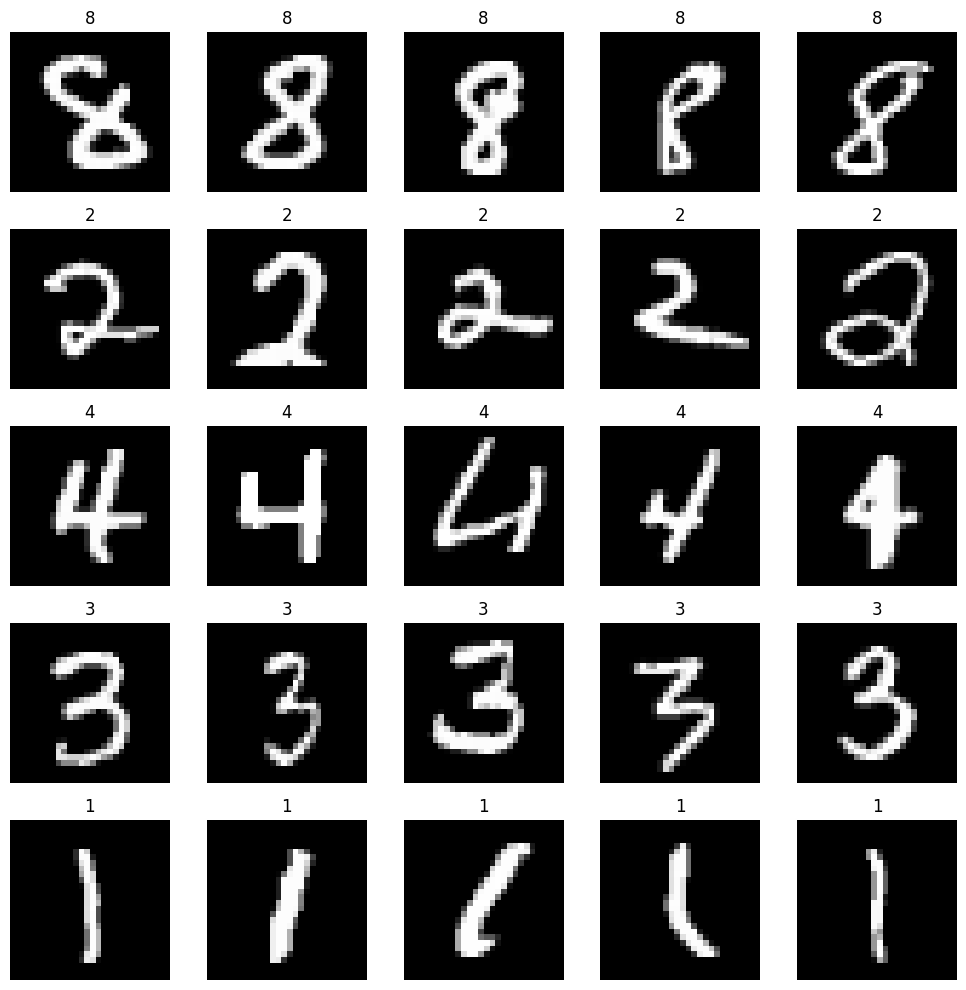

In [7]:
selected_labels = random.sample(classes, 5)

fig, axs = plt.subplots(5, 5, figsize=(10, 10), squeeze=False)
for i in range(5):
    label = selected_labels[i]
    selected_indices = random.sample(torch.where(trainset.dataset.targets == label)[0].tolist(), 5)
    for j in range(5):
        img, label = trainset.dataset[selected_indices[j]]
        axs[i, j].imshow(img.squeeze(), cmap='gray')
        axs[i, j].set_title(label)
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()


In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(
            in_channels=10, out_channels=20, kernel_size=2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        self.fc1 = nn.Linear(in_features=20*5*5, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=10)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.flatten(start_dim=1)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        x = self.softmax(x)
        return x


In [9]:
len(train_loader)


750

In [10]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs=1):
    
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    t = tqdm(total=epochs*len(train_loader), desc="Epoch 0/{}".format(epochs))
    for epoch in range(epochs):  # loop over the dataset multiple times
        t.set_description("Epoch {}/{}".format(epoch,epochs))
        running_loss = 0.0
        correct = 0

        for i, (inputs, labels) in enumerate(train_loader, 0):
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            outputs = torch.argmax(outputs, dim=1)
            correct += (outputs == labels).float().sum()

            running_loss += loss.item()
            t.update(1)
            
        
        loss = running_loss / len(train_loader)
        accuracy = 100*correct/len(train_loader.dataset)
        train_loss.append(loss)
        train_acc.append(accuracy)
        correct = 0
        model.eval()
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_loader, 0):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                outputs = torch.argmax(outputs, dim=1)
                correct += (outputs == labels).float().sum()

                running_loss += loss.item()
            loss = running_loss / len(val_loader)
            accuracy = 100*correct/len(val_loader.dataset)
            val_loss.append(loss)
            val_acc.append(accuracy)

        model.train()
    t.close()

    print('Finished Training')
    return train_loss, val_loss, train_acc, val_acc


In [11]:
model = CNN()

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss, val_loss, train_acc, val_acc = train(
    model, train_loader, val_loader, criterion, optimizer, epochs=10)


Epoch 8/10:  90%|████████▉ | 6747/7500 [03:44<00:21, 34.60it/s]

In [16]:
print(train_acc)
# print(val_acc)

fig, axs = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)


axs[0,0].plot(train_loss, label='train')
axs[0, 0].plot(val_loss, label='val')
axs[0, 0].set_title('Loss vs Epochs')
axs[0, 0].legend()
# axs[0, 0].show()


axs[0, 1].plot(train_acc, label='train')
axs[0, 1].plot(val_acc, label='val')
axs[0, 1].set_title('Accuracy vs Epochs')
axs[0, 1].legend()
plt.show()

NameError: name 'train_acc' is not defined

In [17]:
def test(model, test_dataloader):
    model.eval()
    with torch.no_grad():
        y_test = []
        y_pred = []
        for inputs, labels in test_dataloader:
            y_test.extend(map(int, labels))
            y_pred.extend(model(inputs).argmax(axis=1).cpu().numpy())

    model.train()

    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('F1 score:', f1_score(y_test, y_pred, average='macro'))

    return y_test, y_pred


In [18]:
y_test, y_pred = test(model,test_loader)

NameError: name 'model' is not defined

In [37]:
class CNN_RES(nn.Module):
    def __init__(self):
        super(CNN_RES, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(
            in_channels=10, out_channels=20, kernel_size=2)
        self.conv2_res = nn.Conv2d(
            in_channels=10, out_channels=20, kernel_size=1, stride=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=20*5*5, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=10)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x_res = x

        x = self.conv2(x)
        x = self.relu(x)
        # print(x_res.shape)
        # print(self.pool(x).shape , self.conv2_res(x_res).shape)
        x = self.pool(x) + self.conv2_res(x_res)
        # print(x.shape)
        
        
        x = x.flatten(start_dim=1)
        # print(x.shape)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        x = self.softmax(x)
        # assert 1 == 2
        return x


In [38]:
model_res = CNN_RES()

criterion_res = nn.CrossEntropyLoss()

optimizer_res = optim.Adam(model_res.parameters(), lr=0.001)

train_loss, val_loss, train_acc, val_acc = train(
    model_res, train_loader, val_loader, criterion_res, optimizer_res, epochs=10)


KeyboardInterrupt: 